In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
from pathlib import Path
import time
import math
from typing import Union
import os
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt
import tree_segmentation as ts
from semantic_sam import semantic_sam_l
import torch_geometric as pyg
from tree_segmentation.extension import Mesh, ops_3d, utils
from tree_segmentation import TreeData, Tree3Dv2, Tree3D
import open3d as o3d
import struct

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-02 12:11:20.375594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 12:11:21.405471: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-02 12:11:21.405592: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
device = torch.device('cuda')
torch.set_grad_enabled(False)
glctx = dr.RasterizeCudaContext()

2.0.1+cu117


In [3]:
data_root = Path('~/data/Replica').expanduser().resolve()
data_dir = data_root.joinpath('room_1')
print('data direcotry:', data_dir)
mesh_path = data_dir.joinpath('mesh.ply')
cache_dir = Path(f'./results/{ts.get_hash_name(mesh_path)}')
print('cache dir:', cache_dir)

data direcotry: /data5/Replica/room_1
cache dir: results/dfa19da2d68639883ce9f71be79210a5


In [4]:
cache_file = cache_dir.joinpath(mesh_path.name).with_suffix('.mesh_cache')
if cache_file.exists() and 0:
    mesh = torch.load(cache_file, map_location=device)  # type: Mesh
else:
    mesh = Mesh.load(mesh_path)
    mesh.float()
    mesh.int()
    mesh = mesh.unit_size()
    mesh_ = mesh.to_open3d()
    print(mesh_)
    mesh_smp = mesh_.simplify_quadric_decimation(target_number_of_triangles=500_000, maximum_error=0.1)
    # mesh_smp = mesh_.simplify_vertex_clustering(target_number_of_triangles=500_000, maximum_error=0.5)
    o3d.io.write_triangle_mesh(cache_dir.joinpath('simplified.ply').as_posix(), mesh_smp)
    mesh = mesh.from_open3d(mesh_smp).cuda().unit_size()
    # print(mesh)
    mesh = mesh.cuda().unit_size()
    cache_dir.mkdir(exist_ok=True)
    torch.save(mesh, cache_file)
    print('save cached mesh to', cache_file)
print(mesh)

<class 'numpy.ndarray'> (645078, 4)
[[0 1 2 3]
 [2 1 0 4]
 [2 5 6 3]
 [7 8 0 3]]
[[0 1 2]
 [0 2 3]
 [2 1 0]
 [2 0 4]
 [2 5 6]
 [2 6 3]
 [7 8 0]
 [7 0 3]]
TriangleMesh with 645512 points and 1290156 triangles.
save cached mesh to results/dfa19da2d68639883ce9f71be79210a5/mesh.mesh_cache
Mesh(vertices=250324, faces=499999, clr, nrm)


# Semantic Segmentation

In [ ]:
semantic_mesh_path = data_dir.joinpath('habitat/mesh_semantic.ply')
assert semantic_mesh_path.exists()
semantic_data = utils.parse_ply(semantic_mesh_path)
print(utils.show_shape(semantic_data))
assert semantic_data[1]['name'] == 'face' and semantic_data[1]['names'][1] == 'object_id'
semantic_label = semantic_data[1]['data'][1]  # type: np.ndarray
semantic_label = np.repeat(semantic_label[:, None], semantic_data[1]['data'][0].shape[1] - 2, axis=1).reshape(-1)
print(semantic_label[:10])
print('semantic_label', utils.show_shape(semantic_label))
N_max = np.max(semantic_label) + 1
gt = Tree3Dv2(mesh, device=device)
gt.masks = torch.zeros((N_max, gt.num_faces + 1), device=device, dtype=torch.bool)
gt.scores = torch.ones((N_max,), device=device)
gt.resize(N_max + 1)
for i in range(N_max):
    gt.node_insert(gt.node_new(), 0)
    gt.masks[i, 1:] = torch.from_numpy(semantic_label == i).to(device)
gt.print_tree()
gt.save(cache_dir.joinpath('gt.tree3dv2'))

In [ ]:
print(np.unique(semantic_label))
print(semantic_label[:10])
print(semantic_label[-10:])

In [ ]:
with data_dir.joinpath('semantic.bin').open('rb') as f:
    labels = np.array(list(struct.iter_unpack('@Q', f.read())), dtype=np.uint64).astype(np.int32)
    print(labels.shape, labels.dtype)
    assert 0 <= labels.min() and labels.max() < mesh.f_pos.shape[0] // 2
with data_dir.joinpath('semantic.json').open('r') as f:
    semantic_info = json.load(f)
print(list(semantic_info.keys()))
children = []
parent = []
names = []
numPrimitives = []
for obj in semantic_info['segmentation']:
    idx = obj['id']
    while len(children) <= idx:
        children.append([])
        parent.append(-1)
        names.append([''])
        numPrimitives.append(0)
    parent[idx] = -1 if obj['parent'] == '' else int(obj['parent'])
    children[idx] = [int(c) for c in obj['children']]
    names[idx] = obj['class']
    numPrimitives[idx] = obj['numPrimitives']
    if len(obj['children']) > 0:
        assert obj['numPrimitives'] == 0
numPrimitives = np.array(numPrimitives)
print(numPrimitives.shape, numPrimitives.dtype)
prefix_sum = np.cumsum(numPrimitives) - numPrimitives
print(prefix_sum[:10], numPrimitives[:10])
for i in range(len(children)):
    for c in children[i]:
        assert parent[c] == i

from rich.console import Console
from rich.tree import Tree

gt = Tree3D(mesh, device=device)
gt.resize(len(children) + 1)


def _make_tree(p, tree_idx, tree_: Tree):
    for c in children[p]:
        ci = gt.node_new()
        gt.node_insert(ci, tree_idx)
        _make_tree(c, ci, tree_.add(f'{names[c]}_{c}'))
    if len(children[p]) == 0:
        s = prefix_sum[p]
        e = s + numPrimitives[p]
        for i in range(s, e):
            gt.face_parent[labels[i] * 2 + 1] = tree_idx
            gt.face_parent[labels[i] * 2 + 2] = tree_idx


console = Console()
show_tree = Tree('root')
for i in range(len(parent)):
    if parent[i] == -1:
        idx = gt.node_new()
        gt.node_insert(idx, 0)
        _make_tree(i, idx, show_tree.add(f'{names[i]}_{i}'))
# console.print(show_tree)
gt.print_tree()
gt.save(cache_dir.joinpath('gt.tree3d'))
gt_v2 = Tree3Dv2.convert(gt)
gt_v2.save(cache_dir.joinpath('gt.tree3dv2'))

# 2D Rendering and Segmentation

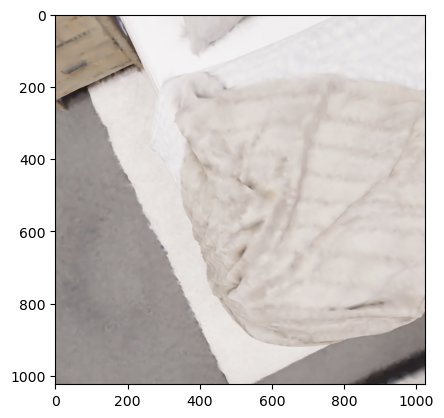

In [5]:
fovy = math.radians(90)
image_size = 1024
Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size)).to(device)
Tw2v = torch.eye(4, device=device)
image, tri_id = ts.render_mesh(glctx, mesh, Tw2v=Tw2v, fovy=fovy, image_size=image_size)
plt.imshow(image.cpu().numpy())

In [6]:
# min_max = mesh.AABB
# print('mesh bounding box:', min_max.tolist())
# min_max = min_max * 0.9
# min_distance = 0.05
# xyz = torch.rand((N, 3), device=device) * (min_max[1] - min_max[0]) + min_max[0]
# print(utils.show_shape(xyz), xyz.aminmax(dim=0))
N = 100
phi_range = [0, math.pi * 2.]
cos_theta_range = [math.cos(0), math.cos(math.pi)]
phis = torch.rand((N,), device=device) * (phi_range[1] - phi_range[0]) + phi_range[0]
thetas = torch.arccos(torch.rand((N,), device=device) * (cos_theta_range[1] - cos_theta_range[0]) + cos_theta_range[0])
radius = torch.zeros((N,), device=device)
at = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
Tw2vs = ops_3d.look_at(at, torch.zeros_like(at))
print(utils.show_shape(Tw2vs))

F32Tensor[100, 4, 4]


In [7]:
"""球面上的均匀格点"""
N = 100
seq = torch.arange(N, device=device)
c = (math.sqrt(5) - 1) * math.pi
z = ((seq * 2 - 1) / N - 1).clamp(-1, 1)
x = torch.sqrt(1 - z * z) * (seq * c).cos()
y = torch.sqrt(1 - z * z) * (seq * c).sin()
at = torch.stack([x, y, z], dim=-1)
at = at * (torch.ones((N, 1), device=device))  # * (radius_range[1] - radius_range[0]) + radius_range[0])
Tw2vs = ops_3d.look_at(torch.zeros_like(at), at)
print(utils.show_shape(Tw2vs), Tw2vs[1])

F32Tensor[100, 4, 4] tensor([[ 0.9945,  0.0000, -0.1045,  0.0000],
        [-0.0100,  0.9954, -0.0948,  0.0000],
        [ 0.1040,  0.0953,  0.9900,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')


F32Tensor[100, 1024, 1024, 3], IntTensor[100, 1024, 1024]


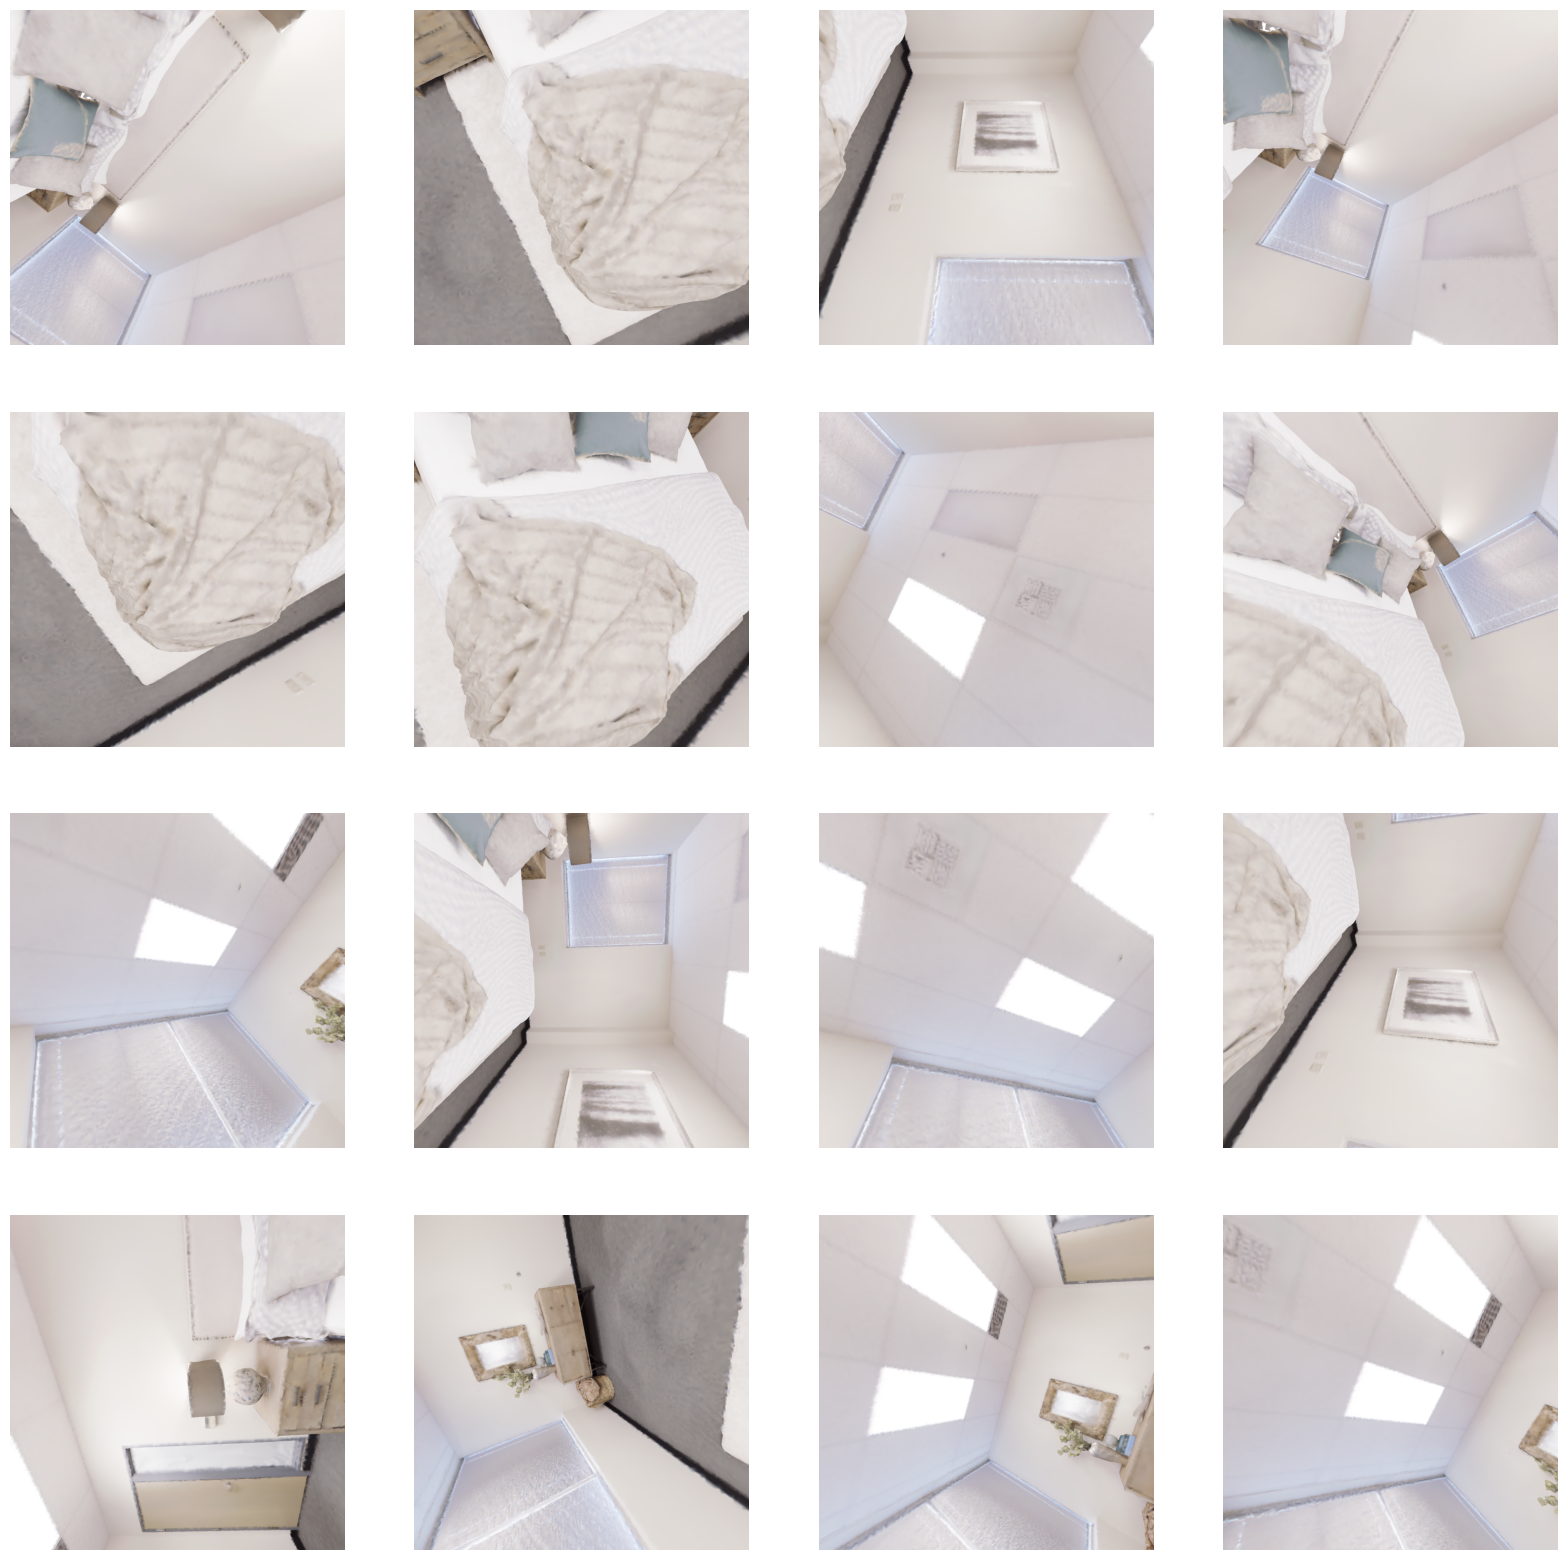

In [8]:
images, tri_ids = [], []
for i in range(0, N, 10):
    images_i, tri_ids_i = ts.render_mesh(
        glctx,
        mesh,
        Tw2v=Tw2vs[i:i + 10],
        image_size=image_size,
        fovy=math.radians(90)
    )
    images.append(images_i.cpu())
    tri_ids.append(tri_ids_i.cpu())
images, tri_ids = torch.cat(images), torch.cat(tri_ids)
print(utils.show_shape(images, tri_ids))
plt.figure(figsize=(20, 20))
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    # plt.imshow(images[i].cpu().numpy())
    plt.imshow(images[np.random.randint(0, N)].cpu().numpy())
    plt.axis('off')

In [9]:
print(utils.get_GPU_memory())
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().to(device)
predictor = ts.TreePredictor(model)
print(utils.get_GPU_memory())

(0.9967341423034668, 11.904052734375)
SemanticSAM(
  (backbone): SwinTransformer(
    (patch_embed): PatchEmbed(patch_size=(4, 4), embed_dim=192, flatten=True)
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        SwinTransformerBlock(dim=192, num_heads=6, mlp_ratio=4.0, window_size=12) * 2
        PatchMerging(dim=192)
      )
      (1): BasicLayer(
        SwinTransformerBlock(dim=384, num_heads=12, mlp_ratio=4.0, window_size=12) * 2
        PatchMerging(dim=384)
      )
      (2): BasicLayer(
        SwinTransformerBlock(dim=768, num_heads=24, mlp_ratio=4.0, window_size=12) * 18
        PatchMerging(dim=768)
      )
      (3): BasicLayer(SwinTransformerBlock(dim=1536, num_heads=48, mlp_ratio=4.0, window_size=12) * 2)
    )
    (norm_4): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (norm_8): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (norm_16): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (norm_

image: F32Tensor[1024, 1024, 3]
[Tree2D] 16 union with [(1, 0.13560950756072998)]
complete init segmentation
complete iter 0 update segmentation
complete iter 1 update segmentation
complete iter 2 update segmentation
complete iter 3 update segmentation
complete iter 4 update segmentation
complete iter 5 update segmentation
complete iter 6 update segmentation
complete iter 7 update segmentation
complete iter 8 update segmentation
complete iter 9 update segmentation
complete iter 10 update segmentation
complete iter 11 update segmentation
complete iter 12 update segmentation
complete iter 13 update segmentation
complete iter 14 update segmentation
complete iter 15 update segmentation
[Tree2D] 32 union with [(1, 0.25535428524017334)]
[Tree2D] 33 union with [(5, 0.14542566239833832)]
[Tree2D] 38 union with [(1, 0.2929297685623169), (7, 0.1339709311723709)]
complete iter 16 update segmentation
[Tree2D] 32 union with [(1, 0.29571497440338135), (7, 0.13351374864578247)]
[Tree2D] 35 union with

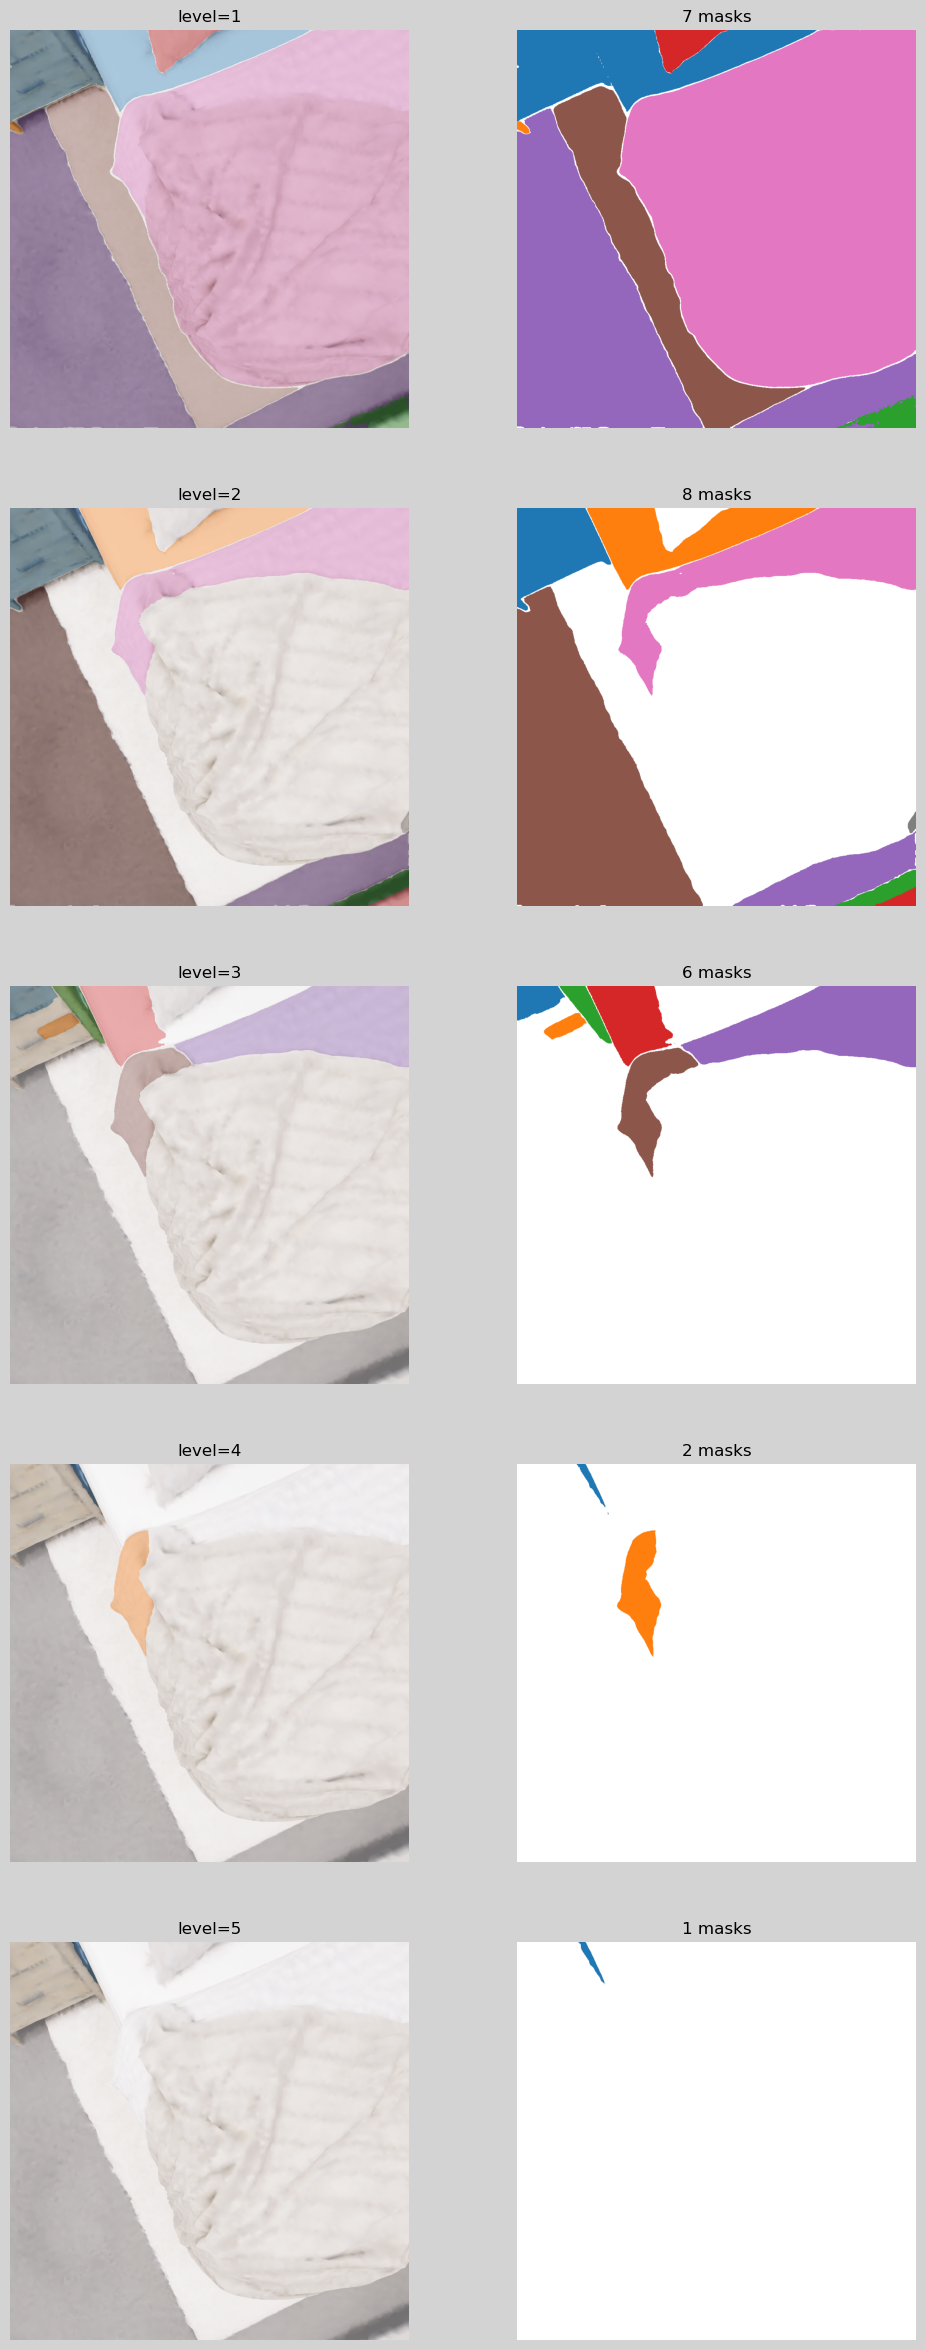

In [10]:
show_index = 0
image = images[show_index, :, :, :3]
print('image:', utils.show_shape(image))
tree_data = predictor.generate(
    (image.cpu().numpy() * 255).astype(np.uint8),
    max_iters=100,
    in_threshold=0.9,
    union_threshold=0.1,
    min_mask_region_area=100,
    points_per_update=256,
    device=device,
    in_thre_area=50,
)
ts.show_all_levels(image, tree_data, facecolor='lightgray', width=6)
print(utils.get_GPU_memory())
del tree_data
torch.cuda.empty_cache()
print(utils.get_GPU_memory())

In [11]:
# from rich.progress import track
from IPython.display import clear_output

for index in tqdm(range(N)):
    # if cache_dir.joinpath(f"view_{index:04d}.data").exists():
    #     continue
    tree_data = predictor.generate(
        (images[index, :, :, :3].cpu().numpy() * 255).astype(np.uint8),
        max_iters=100,
        in_threshold=0.9,
        union_threshold=0.1,
        min_mask_region_area=100,
        points_per_update=256,
        device=device,
        in_thre_area=50,
    )
    data = {
        'tree_data': tree_data.save(filename=None),
        'tri_id': tri_ids[index].clone(),
        'image': images[index].clone(),
        'Tw2v': Tw2vs[index].clone(),
    }
    torch.save(data, cache_dir.joinpath(f"view_{index:04d}.data"))

    clear_output(wait=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [38:19<00:00, 23.00s/it]


In [12]:
tree3d = Tree3Dv2(mesh, device=device, verbose=1)
# tree3d.load(cache_dir.joinpath('my.tree3dv2'))
tree3d.load_2d_results(cache_dir, pack=True)

[Tree] reset
[Tree3D] GPU: (7.688403129577637, 11.904052734375)
[Tree3D] There are 100 data
[Tree3D] {'tree_data': {'masks': IntTensor[4, 1024, 1024], 'iou_preds': F16Tensor[25], 'area': LongTensor[25], 'parent': IntTensor[26], 'first': IntTensor[26], 'next': IntTensor[26], 'last': IntTensor[26], 'cnt': 25, 'num_samples': IntTensor[26], 'extra': {}}, 'tri_id': IntTensor[1024, 1024], 'image': F32Tensor[1024, 1024, 3], 'Tw2v': F32Tensor[4, 4]}
[Tree3D] GPU: (1.0873651504516602, 11.904052734375)
[Tree3D] view_masks, view_infos[0]: BoolTensor[100, 500000], (IntTensor[28313], LongTensor[28313])
[Tree3D] loaded 100 views, 4600 masks, max_num: 90
[Tree3D] GPU: (4.874648094177246, 11.904052734375)


In [13]:
print(tree3d.masks_2d.numel()*1e-9)
print(tree3d._masks_2d_sp.numel()*1e-9)

0.2725
2.3000000000000003


In [14]:
Gv = tree3d.build_view_graph()
Gm = tree3d.build_graph(Gv)
X, autoencoder = tree3d.compress_masks(epochs=5000)
print(autoencoder)
print(utils.get_GPU_memory())

[Tree3D] start build view graph
[Tree3D] start build graph
[Tree3D] X epoch[   0], loss: recon= 0.711, lr=1.000e-03
[Tree3D] X epoch[ 100], loss: recon= 0.150, lr=9.990e-04
[Tree3D] X epoch[ 200], loss: recon= 0.032, lr=9.960e-04
[Tree3D] X epoch[ 300], loss: recon= 0.029, lr=9.911e-04
[Tree3D] X epoch[ 400], loss: recon= 0.026, lr=9.842e-04
[Tree3D] X epoch[ 500], loss: recon= 0.022, lr=9.755e-04
[Tree3D] X epoch[ 600], loss: recon= 0.016, lr=9.648e-04
[Tree3D] X epoch[ 700], loss: recon= 0.012, lr=9.523e-04
[Tree3D] X epoch[ 800], loss: recon= 0.010, lr=9.381e-04
[Tree3D] X epoch[ 900], loss: recon= 0.009, lr=9.221e-04
[Tree3D] X epoch[1000], loss: recon= 0.008, lr=9.044e-04
[Tree3D] X epoch[1100], loss: recon= 0.007, lr=8.852e-04
[Tree3D] X epoch[1200], loss: recon= 0.006, lr=8.644e-04
[Tree3D] X epoch[1300], loss: recon= 0.006, lr=8.422e-04
[Tree3D] X epoch[1400], loss: recon= 0.005, lr=8.187e-04
[Tree3D] X epoch[1500], loss: recon= 0.005, lr=7.938e-04
[Tree3D] X epoch[1600], loss:

In [15]:
K = tree3d.Lmax * 2
gnn = pyg.nn.GCN(
    in_channels=X.shape[1],
    hidden_channels=128,
    num_layers=2,
    out_channels=K,
    norm='BatchNorm'
).cuda()
print(gnn)
tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X)
tree3d.save(cache_dir.joinpath('my.tree3dv2'))

GCN(256, 180, num_layers=2)
[Tree3D] GPU: (5.6831817626953125, 11.904052734375)
[Tree3D] GPU: (5.664576053619385, 11.904052734375)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 │   norm='BatchNorm'                                                                        │
│    8 ).cuda()                                                                                    │
│    9 print(gnn)                                                                                  │
│ ❱ 10 tree3d.run(epochs=5000, K=K, gnn=gnn, A=Gm * Gm.ge(0.5), X=X)                               │
│   11 tree3d.save(cache_dir.joinpath('my.tree3dv2'))                                              │
│   12                                                                                             │
│                                                                                                  │
│ /home/wan/Projects/Segmentation/TreeSeg/tree_segmentation/tree_3d_segmentation.py:1218 in run    │
│                                                                                                  │
│   1215 │   │   │   │   # loss_dict = self.loss_fn(S, node_score)                                 │
│   1216 │   │   │   │                                                                             │
│   1217 │   │   │   │   # with torch.autograd.profiler.profile() as prof:                         │
│ ❱ 1218 │   │   │   │   loss_dict = self.calc_losses(                                             │
│   1219 │   │   │   │   │   S,                                                                    │
│   1220 │   │   │   │   │   node_score,                                                           │
│   1221 │   │   │   │   │   view_index,                                                           │
│                                                                                                  │
│ /home/wan/Projects/Segmentation/TreeSeg/tree_segmentation/tree_3d_segmentation.py:1118 in        │
│ calc_losses                                                                                      │
│                                                                                                  │
│   1115 │   │   │   topP = topP.softmax(dim=1)                                                    │
│   1116 │   │   │   P = torch.scatter(torch.zeros_like(logits), 1, indices, topP).T               │
│   1117 │   │                                                                                     │
│ ❱ 1118 │   │   masks = self._get_masks(P)  # [K, F+1]                                            │
│   1119 │   │   if timer is not None:                                                             │
│   1120 │   │   │   timer.log('get masks')                                                        │
│   1121 │   │   # 评估Masks投影到当前view后的masks与当前view检测出的结果之间的差别                │
│                                                                                                  │
│ /home/wan/Projects/Segmentation/TreeSeg/tree_segmentation/tree_3d_segmentation.py:1093 in        │
│ _get_masks                                                                                       │
│                                                                                                  │
│   1090 │                                                                                         │
│   1091 │   def _get_masks(self, P: Tensor, eps=1e-7):                                            │
│   1092 │   │   # P shape: [K, M]                                                                 │
│ ❱ 1093 │   │   weights = (P @ self.masks_view[self.indices_view].float()).clamp_min(eps)         │
│   1094 │   │   assert P.shape[1] == self.M                                                       │
│   1095 │   │   if self._masks_2d_packed:                                          

In [ ]:
show_index = 8
ts.show_all_levels(images[show_index, :, :, :3], tree3d, tri_ids[show_index])
tree3d.print_tree()

In [ ]:
# metric = ts.TreeSegmentMetric()
# metric.update(tree3d.to(device), gt_v2.to(device))
# print(metric.summarize(), metric.gt_iou_sum / metric.cnt)